In [12]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import weatherbench2 as wb
import metpy
import copy
import wrf
import time
from metpy.units import units
import cartopy.crs as ccrs
sys.path.append('/users/mfeldman/code/xarray_parcel/')
import modules.parcel_functions as parcel
parcel.load_moist_adiabat_lookups()
print('modules loaded')

modules loaded


In [13]:
hres='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
pangu='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
datasets=[era5,hres,pangu]

for dataset in datasets[:1]:
    print(dataset)
    xr_dataset=xr.open_zarr(dataset)
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.year.isin([2020]))
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([4]))#np.arange(3,10)))
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([12,13]))
    xr_dataset = xr_dataset.sortby('level', ascending=False)
    #xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([12]))
    print(xr_dataset.time)
    #xr_dataset=xr_dataset.drop_dims("time")
    plevel=copy.deepcopy(xr_dataset.level.values)
    #xr_dataset.level=np.arange(len(plevel))
    
    #xr_dataset = xr_dataset.assign(pressure=('level'), data=plevel)
    xr_dataset['pressure'] = (('level'), plevel)
    plevel=xr_dataset.pressure
    xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))

    tlevel=xr_dataset.temperature
    qlevel=xr_dataset.specific_humidity
    plevel_dim=np.ones([1,len(plevel),1,1])
    zlevel=xr_dataset.geopotential
    ulevel=xr_dataset.u_component_of_wind
    vlevel=xr_dataset.v_component_of_wind
    for n1 in range(len(plevel.data)):
        plevel_dim[0,n1,0,0]=plevel[n1]
    plevel_exp=(tlevel/tlevel)*plevel_dim
    dplevel=metpy.calc.dewpoint_from_specific_humidity(plevel_exp* units('hPa'), tlevel* units('K'), qlevel* units('kg/kg'))#.magnitude
    dplevel.data=dplevel.data.to(units.K).magnitude

gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr
<xarray.DataArray 'time' (time: 8)>
array(['2020-04-12T00:00:00.000000000', '2020-04-12T06:00:00.000000000',
       '2020-04-12T12:00:00.000000000', '2020-04-12T18:00:00.000000000',
       '2020-04-13T00:00:00.000000000', '2020-04-13T06:00:00.000000000',
       '2020-04-13T12:00:00.000000000', '2020-04-13T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-04-12 ... 2020-04-13T18:00:00


/tmp/ipykernel_2970383/1365173414.py:33: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_specific_humidity(plevel_exp* units('hPa'), tlevel* units('K'), qlevel* units('kg/kg'))#.magnitude


In [14]:
    psurf=xr_dataset.mean_sea_level_pressure
    tsurf=xr_dataset['2m_temperature']
    zsurf_c=xr_dataset['geopotential_at_surface']; print(zsurf_c.shape,zsurf_c.dims)
    zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0); print(zsurf.shape)
    n1=0
    pid=np.zeros(psurf.shape)
    for lev in plevel:
        n1+=1
        pid[(pid==0) & (psurf<lev*100)]=n1
    qlow=xr_dataset.specific_humidity.isel(level=0)
    qsurf_interp = xr_dataset.specific_humidity.isel(level=1) + ( (xr_dataset.specific_humidity.isel(level=0) - xr_dataset.specific_humidity.isel(level=1)) \
                                * ((np.log(psurf) - np.log(plevel[0]*100) ) / ( np.log(plevel[1]*100) - np.log(plevel[0]*100) ) ) )

    qsurf = (psurf.data<100000) * qsurf_interp + (psurf.data>=100000) * qlow

    dpsurf=metpy.calc.dewpoint_from_specific_humidity(psurf* units('Pa'), tsurf* units('K'), qsurf* units('kg/kg'))#.magnitude
    dpsurf.data=dpsurf.data.to(units.K).magnitude  
    

(721, 1440) ('latitude', 'longitude')
(8, 721, 1440)


/tmp/ipykernel_2970383/612864762.py:16: UserWarning: Relative humidity >120%, ensure proper units.
  dpsurf=metpy.calc.dewpoint_from_specific_humidity(psurf* units('Pa'), tsurf* units('K'), qsurf* units('kg/kg'))#.magnitude


In [15]:
    print(plevel_exp.shape,tlevel.shape,dplevel.shape,tsurf.shape,psurf.shape,dpsurf.shape,zsurf.shape,zlevel.shape)
    print(parcel.valid_data(xr_dataset, vert_dim='level'))

(8, 13, 721, 1440) (8, 13, 721, 1440) (8, 13, 721, 1440) (8, 721, 1440) (8, 721, 1440) (8, 721, 1440) (8, 721, 1440) (8, 13, 721, 1440)
True


In [16]:
    ps=psurf/100
    zs=zsurf/9.81
    zl=zlevel/9.81
    cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps, ter_follow=False)
    srh=wrf.srhel(u=ulevel, v=vlevel, height=zl, terrain=zs, top=3000.0)
    

In [17]:
print(srh.dims,srh.shape)

('time', 'latitude', 'longitude') (8, 721, 1440)


('mcape_mcin_lcl_lfc', 'time', 'latitude', 'longitude') (4, 8, 721, 1440)
georeferenced plot


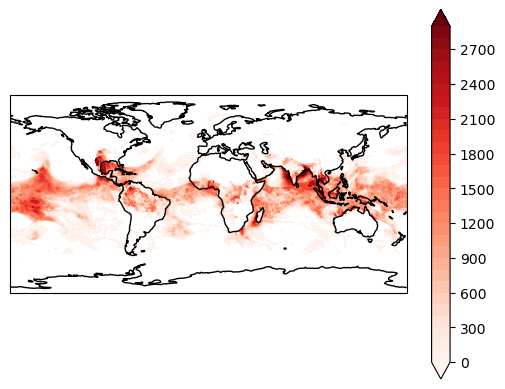

In [18]:
#p=plt.imshow(zl[0,0,:,:]>0); plt.colorbar(p); plt.show()
#p=plt.imshow(zs[0,:,:]>0); plt.colorbar(p); plt.show()
print(cape.dims,cape.shape)
import cartopy.crs as ccrs
#p=plt.imshow(cape[0,2,:,:],vmin=0,vmax=6000,cmap='Reds'); plt.colorbar(p); plt.show()
print('georeferenced plot')#,psurf.longitude,cape.latitude)
ax = plt.axes(projection=ccrs.PlateCarree())
p=plt.contourf(psurf.longitude, psurf.latitude, cape[0,1,:,:],transform=ccrs.PlateCarree(),
               cmap='Reds',vmin=0,vmax=3000,levels=np.arange(0,3000,100),extend='both')
plt.colorbar(p)
ax.coastlines()
plt.show()


In [19]:
figpath='/users/mfeldman/figs/'
cape=cape.assign_coords(longitude=psurf.longitude.values); cape=cape.assign_coords(latitude=psurf.latitude.values); cape=cape.assign_coords(time=psurf.time.values)
#print(cape.mcape_mcin_lcl_lfc,cape.latitude,cape.time,psurf.latitude,psurf.time)
cm=plt.cm.Reds
cm.set_under(color="grey")
p = cape.sel(mcape_mcin_lcl_lfc='mcape',latitude=slice(50,20),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=200,vmax=3000,levels=np.arange(200,3000,100),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
#f.set_figheight(3)
f.savefig(figpath+'era5_cape.png',  dpi=300, bbox_inches='tight')
plt.close()


In [20]:
srh=srh.assign_coords(longitude=psurf.longitude.values); srh=srh.assign_coords(latitude=psurf.latitude.values); srh=srh.assign_coords(time=psurf.time.values)
#print(cape.mcape_mcin_lcl_lfc,cape.latitude,cape.time,psurf.latitude,psurf.time)
cm=plt.cm.Reds
cm.set_under(color="grey")
p = srh.sel(latitude=slice(50,20),longitude=slice(250,300)).plot(x="longitude", y="latitude", col="time", col_wrap=4,transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}\
                ,cmap=cm,vmin=0,vmax=1000,levels=np.arange(0,1000,50),extend='both')# col_wrap=4)
for ax in p.axs.flat:
                ax.coastlines()
f=p.fig
#f.set_figheight(3)
f.savefig(figpath+'era5_srh.png',  dpi=300, bbox_inches='tight')
plt.close()

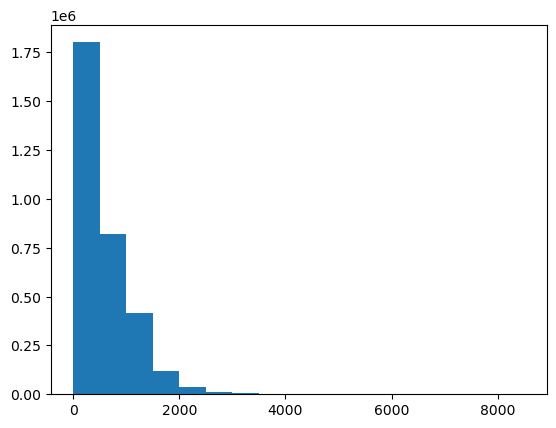

0

In [9]:
plt.hist(cape.data[0,:,:,:].flatten(),bins=np.arange(0,9000,500)); plt.show()
np.nansum(cape.data[0,:,:,:]>8000)


In [48]:
##CAPE IN XARRAY PARCEL, PRODUCING ERRORS
    #print('begin CAPE computation')
    #cape_cin, array = parcel.cape_cin(plevel.chunk(), tlevel.chunk(), dplevel.chunk(), tsurf.chunk(), psurf.chunk(),
    #         dpsurf.chunk(), vert_dim='level')
